# Module

In [1]:
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, PowerTransformer, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import HistGradientBoostingRegressor

import optuna
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="seaborn")
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

In [3]:
%matplotlib inline
plt.style.use('ggplot')

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [4]:
np.random.seed(2024)
random.seed(2024)

# Func

In [5]:
def load_data():    
    train = pd.read_csv('data/train.csv')
    test = pd.read_csv('data/test.csv')    
    all_df = pd.concat([train, test], sort=False).reset_index(drop=True)
    return train, test, all_df

def skewed(df, all_df):
    pt = PowerTransformer(method='yeo-johnson') # yeo-johnson : 음수값 포함, box-cox : 양수값만
    pt.fit(df[['Annual Income']])
    all_df['transformed_Annual_Income'] = pt.transform(all_df[['Annual Income']])
    all_df['log_Premium_Amount'] = np.log1p(all_df['Premium Amount'])
    return pt, all_df
    
def date(df):

    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
    df['Year'] = df['Policy Start Date'].dt.year
    df['Day'] = df['Policy Start Date'].dt.day
    df['Month'] = df['Policy Start Date'].dt.month
    df['Month_name'] = df['Policy Start Date'].dt.month_name()
    df['Day_of_week'] = df['Policy Start Date'].dt.day_name()
    df['Week'] = df['Policy Start Date'].dt.isocalendar().week
    df['Year_sin'] = np.sin(2 * np.pi * df['Year'])
    df['Year_cos'] = np.cos(2 * np.pi * df['Year'])
    min_year = df['Year'].min()
    max_year = df['Year'].max()
    df['Year_sin'] = np.sin(2 * np.pi * (df['Year'] - min_year) / (max_year - min_year))
    df['Year_cos'] = np.cos(2 * np.pi * (df['Year'] - min_year) / (max_year - min_year))
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12) 
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)  
    df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)
    df['Group']=(df['Year']-2020)*48+df['Month']*4+df['Day']//7
    
    df.drop('Policy Start Date', axis=1, inplace=True)

    return df

def fe(df):
    df['contract length'] = pd.cut(
        df["Insurance Duration"].fillna(99),  
        bins=[-float('inf'), 1, 3, float('inf')],  
        labels=[0, 1, 2]  
    ).astype(int)

    return df

def prep():
    train, test, all_df = load_data()
    pt, all_df = skewed(train, all_df)
    all_df = date(all_df)
    all_df = fe(all_df)
    train = all_df[~all_df['Premium Amount'].isnull()]
    test = all_df[all_df['Premium Amount'].isnull()]
    return train, test, all_df

train, test, all_df = prep()

# NaN Values

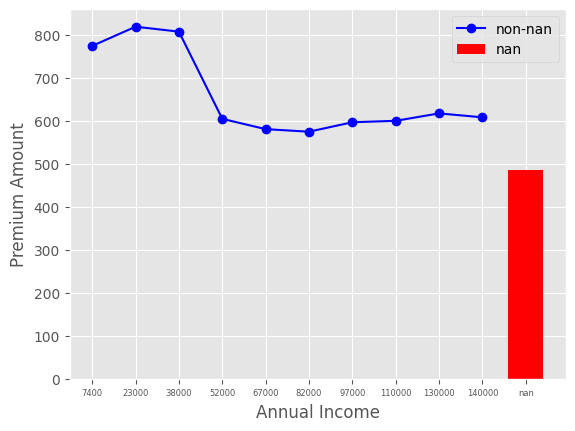

In [7]:
def plot_nan(train, x_col='Annual Income', y_col='Premium Amount', bins=10):

    df = pd.DataFrame({
        x_col: pd.cut(train[x_col].dropna(), bins),  # NaN 제외
        y_col: train[y_col] # NaN 제외
    })

    s = df.groupby(x_col, observed=True, dropna=False).agg(
        lambda x: np.expm1(np.log1p(x).mean())).reset_index()

    def label(x):
        if isinstance(x, float):
            return x
        x = x.mid
        s = int(np.floor(np.log10(x)))
        return int(round(x, -s+1))

    plt.plot(s[:-1][y_col], 'bo-', label='non-nan')  # NaN 제외한 그래프
    plt.bar(bins, s.iloc[-1][y_col], color='red', label='nan')
    plt.xticks(range(len(s)), labels=s[x_col].apply(label), fontsize=6)
    plt.xlabel(x_col); plt.ylabel(y_col)
    plt.legend(loc='best')
    plt.show()

plot_nan(train)

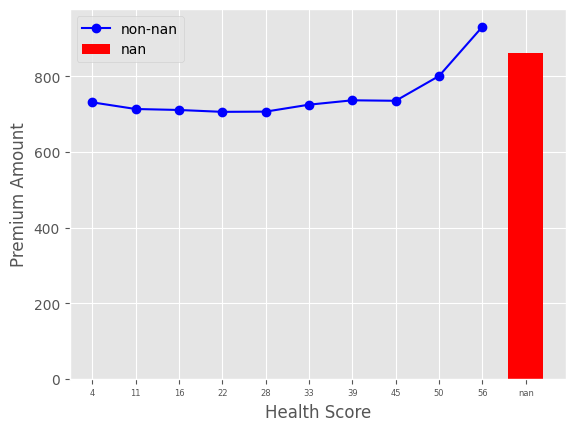

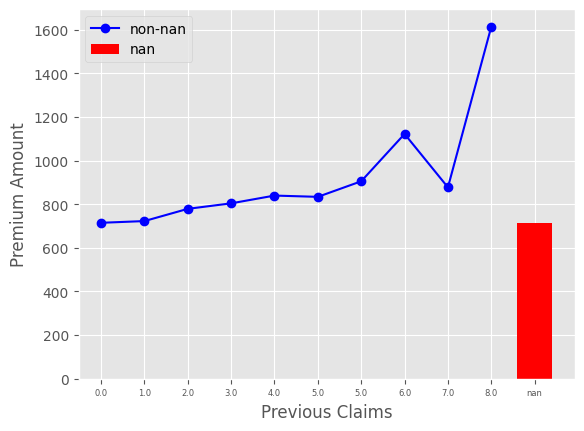

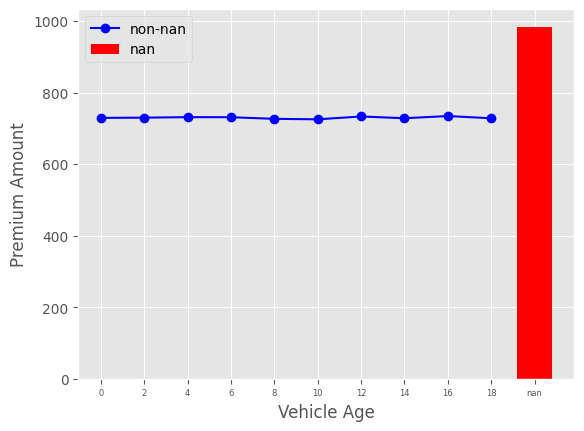

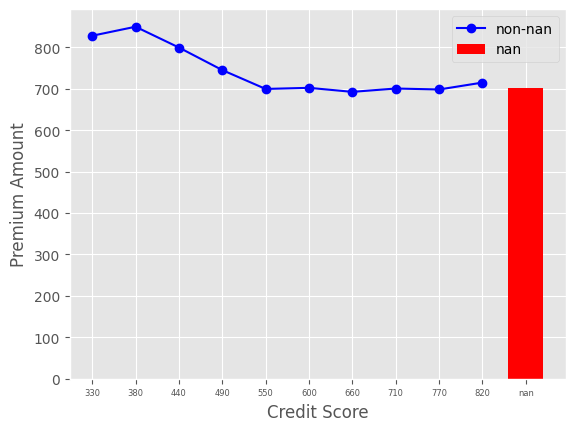

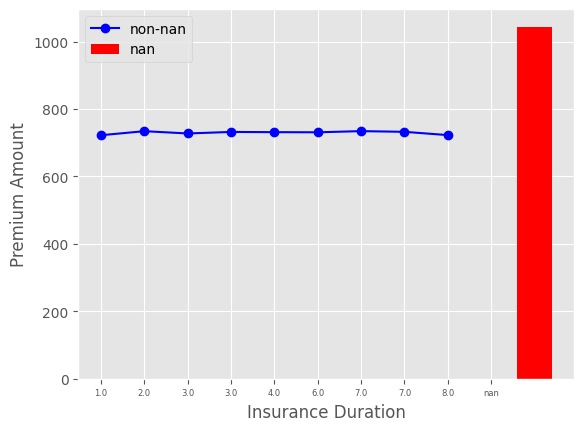

In [8]:
missing_cols = ['Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration']
for col in missing_cols:
    plot_nan(train, x_col=col)

/tmp/ipykernel_117869/1463196535.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['is_nan'] = train[x_col].isnull().astype(int)


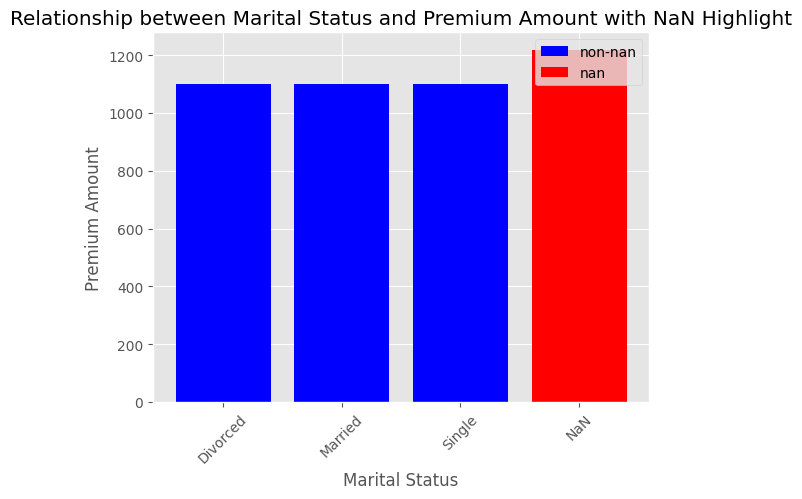

/tmp/ipykernel_117869/1463196535.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['is_nan'] = train[x_col].isnull().astype(int)


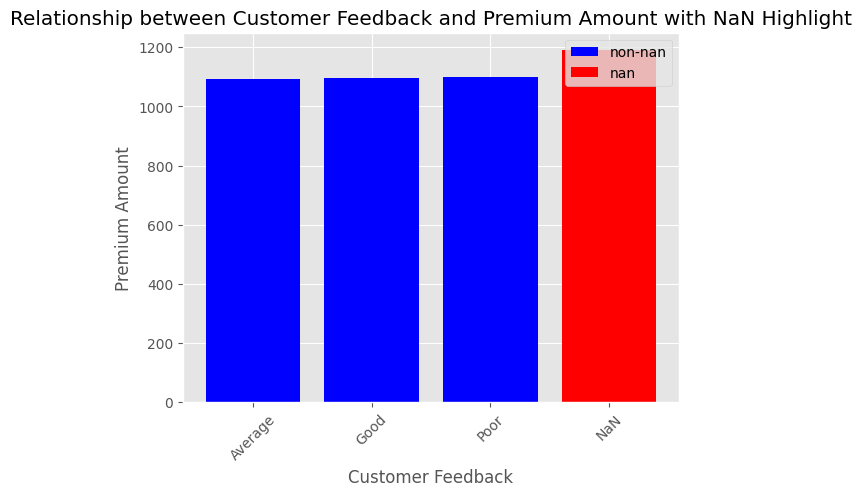

In [9]:
def plot_nan_categorical(train, x_col, y_col='Premium Amount'):
    # NaN 여부 구분
    train['is_nan'] = train[x_col].isnull().astype(int)

    # 그룹화 - NaN 여부로 평균 계산
    grouped = train.groupby([x_col])[y_col].mean().reset_index()

    # NaN이 아닌 경우 (파란색)
    plt.bar(grouped[x_col].astype(str), grouped[y_col], color='blue', label='non-nan')

    # NaN 처리 (붉은 막대 추가)
    nan_mask = train[x_col].isnull()  # NaN 필터 생성
    if nan_mask.sum() > 0:  # NaN이 존재할 때만 추가
        nan_mean = train.loc[nan_mask, y_col].mean()  # NaN 그룹 평균 계산
        plt.bar('NaN', nan_mean, color='red', label='nan')  # 붉은 막대 추가

    # 그래프 설정
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f'Relationship between {x_col} and {y_col} with NaN Highlight')
    plt.xticks(rotation=45)  # X축 라벨 회전
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

for col in ['Marital Status', 'Customer Feedback']:
    plot_nan_categorical(train, x_col=col)


In [6]:
nan_cols = ['Marital Status', 'Customer Feedback', 'Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration']

for col in nan_cols:
    print(col)
    col_name = col + '_NA'
    all_df[col_name] = all_df[col].isnull().astype(int)

all_df.head()

Marital Status
Customer Feedback
Health Score
Previous Claims
Vehicle Age
Credit Score
Insurance Duration


,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,transformed_Annual_Income,log_Premium_Amount,Year,Day,Month,Month_name,Day_of_week,Week,Year_sin,Year_cos,Month_sin,Month_cos,Day_sin,Day_cos,Group,contract length,Marital Status_NA,Customer Feedback_NA,Health Score_NA,Previous Claims_NA,Vehicle Age_NA,Credit Score_NA,Insurance Duration_NA
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,Poor,No,Weekly,House,2869.0,-0.596487,7.962067,2023,23,12,December,Saturday,51,-9.510565e-01,0.309017,-2.449294e-16,1.000000e+00,-0.998717,-0.050649,195,2,0,0,0,0,0,0,0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,Average,Yes,Monthly,House,1483.0,0.336563,7.302496,2023,12,6,June,Monday,24,-9.510565e-01,0.309017,1.224647e-16,-1.000000e+00,0.651372,-0.758758,169,1,0,0,0,0,0,0,0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,Good,Yes,Weekly,House,567.0,0.140781,6.342121,2023,30,9,September,Saturday,39,-9.510565e-01,0.309017,-1.000000e+00,-1.836970e-16,-0.201299,0.979530,184,1,0,0,0,0,0,1,0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,Poor,Yes,Daily,Apartment,765.0,2.088459,6.641182,2024,12,6,June,Wednesday,24,-2.449294e-16,1.000000,1.224647e-16,-1.000000e+00,0.651372,-0.758758,217,0,0,0,0,0,0,0,0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,Poor,Yes,Weekly,House,2022.0,0.555622,7.612337,2021,1,12,December,Wednesday,48,5.877853e-01,-0.809017,-2.449294e-16,1.000000e+00,0.201299,0.979530,96,2,0,0,0,0,0,0,0


# Encoding

In [7]:
def encode_ordinal(df):
    educ = {"High School":0, "Bachelor's":1, "Master's":2, "PhD":3}
    policy = {'Basic':0, 'Comprehensive':1, 'Premium':2}
    exerc = {'Rarely':0, 'Daily':1, 'Weekly':2, 'Monthly': 3}
    feedback = {'Poor':0, 'Average':1, 'Good':2, "Unknown": 0}

    df['Education Level'] = df['Education Level'].map(educ)
    df['Policy Type'] = df['Policy Type'].map(policy)
    df['Exercise Frequency'] = df['Exercise Frequency'].map(exerc)
    df['Customer Feedback'] = df['Customer Feedback'].map(feedback)
    return df

def encode_binary(df):
    df['Gender'] = df['Gender'].map({'Male':0, 'Female':1})
    df['Smoking Status'] = df['Smoking Status'].map({'Yes':1, 'No':0})
    return df

def one_hot_dummies(df, categorical):
    oh = pd.get_dummies(df[categorical])
    df = df.drop(categorical, axis=1)
    return pd.concat([df, oh], axis=1)

all_df = encode_binary(all_df)
all_df = encode_ordinal(all_df)

In [8]:
categorical_features = test.select_dtypes(include='object').columns
categorical_features

Index(['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location',
       'Policy Type', 'Customer Feedback', 'Smoking Status',
       'Exercise Frequency', 'Property Type', 'Month_name', 'Day_of_week'],
      dtype='object')

In [9]:
all_df = one_hot_dummies(all_df, categorical_features)

# New Feature

In [10]:
def add_new_features(df):
    df['Income to Dependents Ratio'] = df['Annual Income'] / (df['Number of Dependents'].fillna(0) + 1)
    df['Income_per_Dependent'] = df['Annual Income'] / (df['Number of Dependents'] + 1)
    df['CreditScore_InsuranceDuration'] = df['Credit Score'] * df['Insurance Duration']
    df['Health_Risk_Score'] = df['Smoking Status'].apply(lambda x: 1 if x == 'Smoker' else 0) + \
                                df['Exercise Frequency'].apply(lambda x: 1 if x == 'Low' else (0.5 if x == 'Medium' else 0)) + \
                                (100 - df['Health Score']) / 20
    df['Credit_Health_Score'] = df['Credit Score'] * df['Health Score']
    df['Health_Age_Interaction'] = df['Health Score'] * df['Age']
    return df

all_df = add_new_features(all_df)

# Train / Test

In [11]:
train = all_df[~all_df['Premium Amount'].isnull()]
test = all_df[all_df['Premium Amount'].isnull()]

train.shape, test.shape

((1200000, 74), (800000, 74))

In [12]:
y = train['log_Premium_Amount']

In [13]:
test.columns

Index(['id', 'Age', 'Annual Income', 'Number of Dependents', 'Health Score',
       'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration',
       'Premium Amount', 'transformed_Annual_Income', 'log_Premium_Amount',
       'Year', 'Day', 'Month', 'Week', 'Year_sin', 'Year_cos', 'Month_sin',
       'Month_cos', 'Day_sin', 'Day_cos', 'Group', 'contract length',
       'Marital Status_NA', 'Customer Feedback_NA', 'Health Score_NA',
       'Previous Claims_NA', 'Vehicle Age_NA', 'Credit Score_NA',
       'Insurance Duration_NA', 'Gender', 'Education Level', 'Policy Type',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Marital Status_Divorced', 'Marital Status_Married',
       'Marital Status_Single', 'Occupation_Employed',
       'Occupation_Self-Employed', 'Occupation_Unemployed', 'Location_Rural',
       'Location_Suburban', 'Location_Urban', 'Property Type_Apartment',
       'Property Type_Condo', 'Property Type_House', 'Month_name_April',
  

# Preprocessing

In [14]:
features = train.columns.drop(['id', 'Premium Amount', 'log_Premium_Amount', 'Annual Income'])
features

Index(['Age', 'Number of Dependents', 'Health Score', 'Previous Claims',
       'Vehicle Age', 'Credit Score', 'Insurance Duration',
       'transformed_Annual_Income', 'Year', 'Day', 'Month', 'Week', 'Year_sin',
       'Year_cos', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', 'Group',
       'contract length', 'Marital Status_NA', 'Customer Feedback_NA',
       'Health Score_NA', 'Previous Claims_NA', 'Vehicle Age_NA',
       'Credit Score_NA', 'Insurance Duration_NA', 'Gender', 'Education Level',
       'Policy Type', 'Customer Feedback', 'Smoking Status',
       'Exercise Frequency', 'Marital Status_Divorced',
       'Marital Status_Married', 'Marital Status_Single',
       'Occupation_Employed', 'Occupation_Self-Employed',
       'Occupation_Unemployed', 'Location_Rural', 'Location_Suburban',
       'Location_Urban', 'Property Type_Apartment', 'Property Type_Condo',
       'Property Type_House', 'Month_name_April', 'Month_name_August',
       'Month_name_December', 'Month_name_Fe

In [15]:
object_columns = train[features].select_dtypes(include='object').columns.to_list()
numerical_columns = train[features].select_dtypes(exclude='object').columns.to_list()

In [16]:
num_preprocessor = Pipeline(steps=[
    ('scaler', RobustScaler())
])

cat_preprocessor = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessors = ColumnTransformer(
    transformers=[
        ('num', num_preprocessor, numerical_columns),
        ('cat', cat_preprocessor, object_columns),
    ]
)

In [17]:
train_prep = preprocessors.fit_transform(train[features])
test_prep = preprocessors.transform(test[features])

train_prep.shape, test_prep.shape

((1200000, 70), (800000, 70))

# LGBM

In [18]:
x_train, x_val, y_train, y_val = train_test_split(train_prep, y, test_size=0.1, random_state=2024)

## Train

In [19]:
# def objective(trial):
#     param = {
#         "objective": "regression",
#         "metric": "rmse",
#         "boosting_type": "gbdt",
#         "num_leaves": trial.suggest_int("num_leaves", 10, 300),
#         "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
#         "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
#         "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
#         "bagging_freq": trial.suggest_int("bagging_freq", 5, 12),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
#         "max_depth": trial.suggest_int("max_depth", -1, 12),  # -1 means no limit
#         "lambda_l1": trial.suggest_float("lambda_l1", 1e-4, 10.0, log=True),
#         "lambda_l2": trial.suggest_float("lambda_l2", 1e-4, 10.0, log=True),
#         "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.001, 0.1),
#         "device_type": "cpu",
#         "seed" : 2024,
#         'verbose':-1 # no warning msg
#     }

#     dtrain = lgb.Dataset(x_train, label=y_train)
#     dval = lgb.Dataset(x_val, label=y_val, reference=dtrain)

#     callbacks=[
#         lgb.log_evaluation(period=50)
#     ]

#     model = lgb.train(
#         param,
#         dtrain,
#         num_boost_round=300,
#         valid_sets=[dtrain, dval],
#         valid_names=['train', 'valid'],
#         callbacks=callbacks
#     )

#     y_val_pred = model.predict(x_val, num_iteration=model.best_iteration)
#     rmse = root_mean_squared_error(y_val, np.maximum(y_val_pred, 0))
#     return rmse

# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=10)
# study.best_params

In [19]:
best_params = {
  'objective': 'regression',
  'metric': 'rmse',
  'boosting_type': 'gbdt',
  'num_leaves': 223,
  'learning_rate': 0.013448761496300131,
  'feature_fraction': 0.976921181722515,
  'bagging_fraction': 0.7872058648019906,
  'bagging_freq': 8,
  'min_data_in_leaf': 40,
  'max_depth': 7,
  'lambda_l1': 0.6235555165474294,
  'lambda_l2': 5.63421906705429,
  'min_gain_to_split': 0.09441706957215877,
  'device_type': "cpu",
  'seed' : 2024,
  'verbose':-1
}

lgb_train = lgb.Dataset(x_train, label=y_train)
lgb_val = lgb.Dataset(x_val, label=y_val, reference=lgb_train)

callbacks = [
    lgb.early_stopping(200),
    lgb.log_evaluation(period=50)
]

model_lgb = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=1500,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'valid'],
    callbacks=callbacks
)

Training until validation scores don't improve for 200 rounds
[50]	train's rmse: 1.0597	valid's rmse: 1.0621
[100]	train's rmse: 1.04913	valid's rmse: 1.05191
[150]	train's rmse: 1.04557	valid's rmse: 1.04887
[200]	train's rmse: 1.04411	valid's rmse: 1.04797
[250]	train's rmse: 1.04321	valid's rmse: 1.04765
[300]	train's rmse: 1.04255	valid's rmse: 1.04748
[350]	train's rmse: 1.04194	valid's rmse: 1.04739
[400]	train's rmse: 1.04136	valid's rmse: 1.04733
[450]	train's rmse: 1.04082	valid's rmse: 1.04728
[500]	train's rmse: 1.0403	valid's rmse: 1.04726
[550]	train's rmse: 1.03978	valid's rmse: 1.04723
[600]	train's rmse: 1.03932	valid's rmse: 1.04719
[650]	train's rmse: 1.03885	valid's rmse: 1.0472
[700]	train's rmse: 1.03838	valid's rmse: 1.04719
[750]	train's rmse: 1.03792	valid's rmse: 1.04717
[800]	train's rmse: 1.03741	valid's rmse: 1.04717
[850]	train's rmse: 1.03695	valid's rmse: 1.04711
[900]	train's rmse: 1.03643	valid's rmse: 1.04712
[950]	train's rmse: 1.03595	valid's rmse: 1

## Evaluation

In [21]:
y_val_pred_lgb = model_lgb.predict(x_val, num_iteration=model_lgb.best_iteration)

rmse = root_mean_squared_error(y_val, y_val_pred_lgb)
mae = mean_absolute_error(y_val, y_val_pred_lgb)
r2 = r2_score(y_val, y_val_pred_lgb)

print(f"\nPerformance Metrics:\n{'-'*25}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


Performance Metrics:
-------------------------
RMSE: 1.0471
MAE: 0.7439
R²: 0.0901


/tmp/ipykernel_150851/1717357675.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(15), x='Importance', y='Feature', palette="coolwarm")


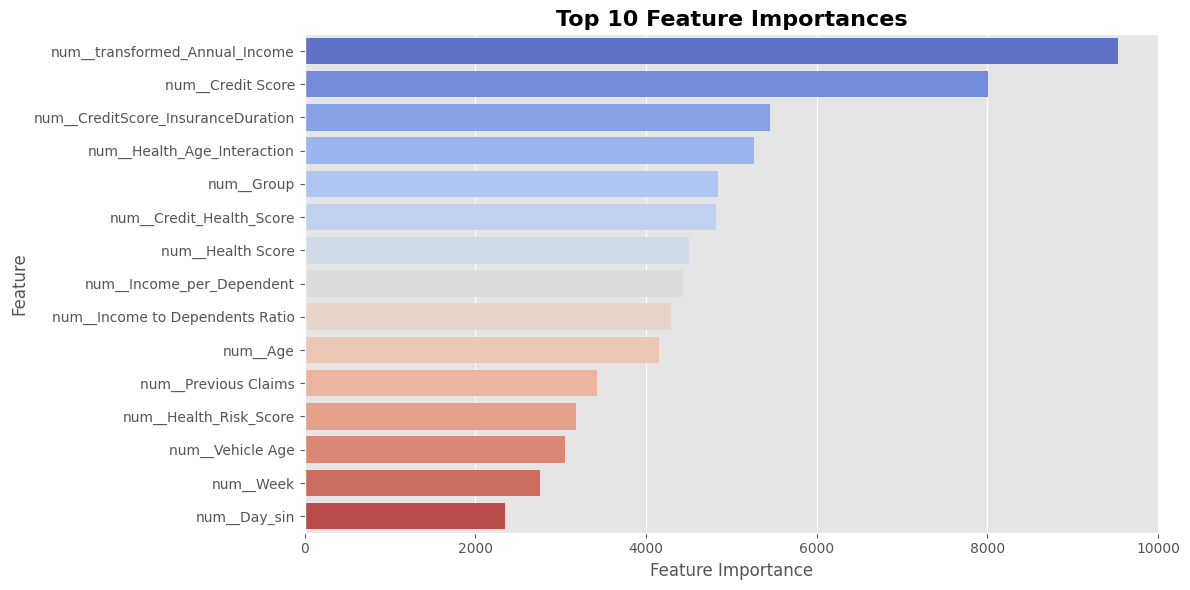

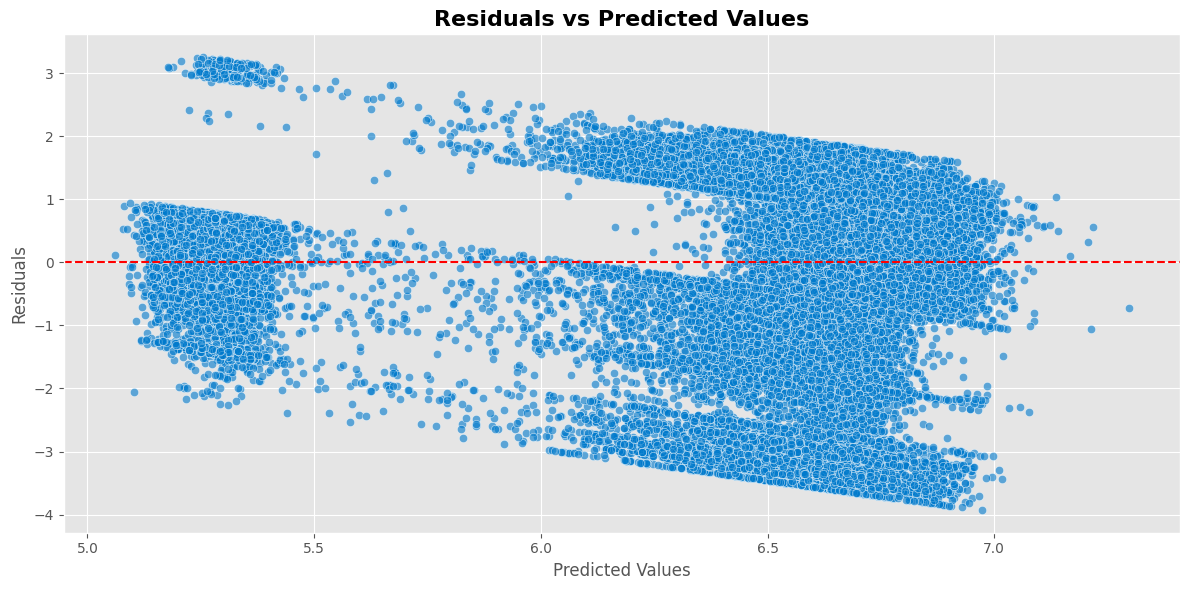

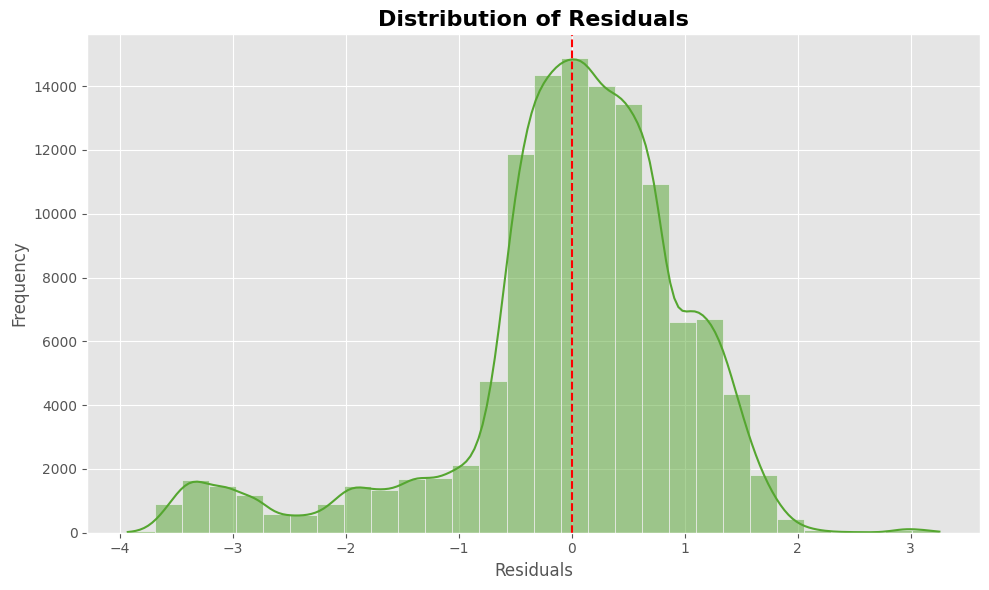

In [22]:
importances = model_lgb.feature_importance(importance_type='split')  # or 'gain'
features = preprocessors.get_feature_names_out()
sorted_indices = importances.argsort()[::-1]

importance_df = pd.DataFrame({
    'Feature': [features[i] for i in sorted_indices],
    'Importance': importances[sorted_indices]
})

plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df.head(15), x='Importance', y='Feature', palette="coolwarm")
plt.title("Top 10 Feature Importances", fontsize=16, fontweight='bold')
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

residuals = y_val - y_val_pred_lgb

plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_val_pred_lgb, y=residuals, alpha=0.6, color="#007acc")
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.title("Residuals vs Predicted Values", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True, color="#55a630")
plt.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
plt.title("Distribution of Residuals", fontsize=16, fontweight='bold')
plt.xlabel("Residuals", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

# XGBoost

In [23]:
# def objective(trial):
#     param = {
#         "objective": "reg:squarederror",
#         "eval_metric": "rmse",
#         "booster": "gbtree",
#         "eta": trial.suggest_float("eta", 1e-4, 1e-1, log=True),
#         "max_depth": trial.suggest_int("max_depth", 3, 12),
#         "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
#         "subsample": trial.suggest_float("subsample", 0.6, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
#         "lambda": trial.suggest_float("lambda", 1e-4, 10.0, log=True),
#         "alpha": trial.suggest_float("alpha", 1e-4, 10.0, log=True),
#         "gamma": trial.suggest_float("gamma", 0.001, 0.1),
#         "seed": 2024,
#         "verbosity": 0
#     }

#     dtrain = xgb.DMatrix(x_train, label=y_train)
#     dval = xgb.DMatrix(x_val, label=y_val)

#     model = xgb.train(
#         param,
#         dtrain,
#         num_boost_round=300,
#         evals=[(dtrain, 'train'), (dval, 'valid')],
#         early_stopping_rounds=50,
#         verbose_eval=50
#     )

#     y_val_pred = model.predict(dval, iteration_range=(0, model.best_iteration + 1))
#     rmse = root_mean_squared_error(y_val, np.maximum(y_val_pred, 0))
#     return rmse

# xgb_study = optuna.create_study(direction="minimize")
# xgb_study.optimize(objective, n_trials=5)
# xgb_study.best_params

[I 2024-12-26 11:16:52,046] A new study created in memory with name: no-name-b99ae68f-afab-466a-b2e5-96905fc18c84


[0]	train-rmse:1.09519	valid-rmse:1.09734
[50]	train-rmse:1.07958	valid-rmse:1.08206
[100]	train-rmse:1.06881	valid-rmse:1.07163
[150]	train-rmse:1.06146	valid-rmse:1.06466
[200]	train-rmse:1.05610	valid-rmse:1.05971
[250]	train-rmse:1.05216	valid-rmse:1.05618
[299]	train-rmse:1.04932	valid-rmse:1.05375


[I 2024-12-26 11:18:03,600] Trial 0 finished with value: 1.0537453697801804 and parameters: {'eta': 0.004682790882851532, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.8440069576066571, 'colsample_bytree': 0.7161939775803253, 'lambda': 0.02461331214637332, 'alpha': 0.003747002847962138, 'gamma': 0.08062455402429192}. Best is trial 0 with value: 1.0537453697801804.


[0]	train-rmse:1.09559	valid-rmse:1.09773
[50]	train-rmse:1.09461	valid-rmse:1.09683
[100]	train-rmse:1.09365	valid-rmse:1.09596
[150]	train-rmse:1.09270	valid-rmse:1.09508
[200]	train-rmse:1.09177	valid-rmse:1.09423
[250]	train-rmse:1.09085	valid-rmse:1.09339
[299]	train-rmse:1.08996	valid-rmse:1.09257


[I 2024-12-26 11:19:49,734] Trial 1 finished with value: 1.0925743044992426 and parameters: {'eta': 0.0001898121726375231, 'max_depth': 11, 'min_child_weight': 9, 'subsample': 0.9199688437132432, 'colsample_bytree': 0.9013747846404558, 'lambda': 0.0002563320865942985, 'alpha': 6.000860992892456, 'gamma': 0.036230214089221204}. Best is trial 0 with value: 1.0537453697801804.


[0]	train-rmse:1.09462	valid-rmse:1.09692
[50]	train-rmse:1.05955	valid-rmse:1.06986
[100]	train-rmse:1.03895	valid-rmse:1.05751
[150]	train-rmse:1.02627	valid-rmse:1.05255
[200]	train-rmse:1.01635	valid-rmse:1.05016
[250]	train-rmse:1.00841	valid-rmse:1.04907
[299]	train-rmse:1.00170	valid-rmse:1.04850


[I 2024-12-26 11:21:48,224] Trial 2 finished with value: 1.0484974330677757 and parameters: {'eta': 0.011539482114280126, 'max_depth': 12, 'min_child_weight': 9, 'subsample': 0.6323143655692255, 'colsample_bytree': 0.602796859912047, 'lambda': 0.15576225445057282, 'alpha': 0.00012835669498272254, 'gamma': 0.07135352121799406}. Best is trial 2 with value: 1.0484974330677757.


[0]	train-rmse:1.09554	valid-rmse:1.09768
[50]	train-rmse:1.09273	valid-rmse:1.09488
[100]	train-rmse:1.09029	valid-rmse:1.09245
[150]	train-rmse:1.08799	valid-rmse:1.09015
[200]	train-rmse:1.08592	valid-rmse:1.08809
[250]	train-rmse:1.08402	valid-rmse:1.08619
[299]	train-rmse:1.08236	valid-rmse:1.08454


[I 2024-12-26 11:22:29,007] Trial 3 finished with value: 1.0845364171672176 and parameters: {'eta': 0.0013347787142351341, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.8056455584815115, 'colsample_bytree': 0.7111353402954085, 'lambda': 0.07009404488670834, 'alpha': 0.006249135422972555, 'gamma': 0.05529930353744867}. Best is trial 2 with value: 1.0484974330677757.


[0]	train-rmse:1.09552	valid-rmse:1.09768
[50]	train-rmse:1.09110	valid-rmse:1.09402
[100]	train-rmse:1.08677	valid-rmse:1.09048
[150]	train-rmse:1.08297	valid-rmse:1.08743
[200]	train-rmse:1.07933	valid-rmse:1.08455
[250]	train-rmse:1.07595	valid-rmse:1.08193
[299]	train-rmse:1.07287	valid-rmse:1.07959


[I 2024-12-26 11:24:35,558] Trial 4 finished with value: 1.0795855732056505 and parameters: {'eta': 0.0009653652190725801, 'max_depth': 12, 'min_child_weight': 7, 'subsample': 0.8251222055684555, 'colsample_bytree': 0.6840180601330546, 'lambda': 0.014008612756890042, 'alpha': 0.5971693501781784, 'gamma': 0.054580925659517464}. Best is trial 2 with value: 1.0484974330677757.


{'eta': 0.011539482114280126,
 'max_depth': 12,
 'min_child_weight': 9,
 'subsample': 0.6323143655692255,
 'colsample_bytree': 0.602796859912047,
 'lambda': 0.15576225445057282,
 'alpha': 0.00012835669498272254,
 'gamma': 0.07135352121799406}

In [24]:
# param_xgb = xgb_study.best_params
param_xgb = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "booster": "gbtree",
        'eta': 0.011539482114280126,
        'max_depth': 12,
        'min_child_weight': 9,
        'subsample': 0.6323143655692255,
        'colsample_bytree': 0.602796859912047,
        'lambda': 0.15576225445057282,
        'alpha': 0.00012835669498272254,
        'gamma': 0.07135352121799406,
        "seed": 2024,
        "verbosity": 0
    }

xgb_train = xgb.DMatrix(x_train, label=y_train)
xgb_val = xgb.DMatrix(x_val, label=y_val)

model_xgb = xgb.train(
    param_xgb,
    xgb_train,
    num_boost_round=1000,
    evals=[(xgb_train, 'train'), (xgb_val, 'valid')],
    early_stopping_rounds=200,
    verbose_eval=50
)

[0]	train-rmse:1.09462	valid-rmse:1.09692
[50]	train-rmse:1.05955	valid-rmse:1.06986
[100]	train-rmse:1.03895	valid-rmse:1.05751
[150]	train-rmse:1.02627	valid-rmse:1.05255
[200]	train-rmse:1.01635	valid-rmse:1.05016
[250]	train-rmse:1.00841	valid-rmse:1.04907
[300]	train-rmse:1.00159	valid-rmse:1.04849
[350]	train-rmse:0.99537	valid-rmse:1.04818
[400]	train-rmse:0.98968	valid-rmse:1.04816
[450]	train-rmse:0.98387	valid-rmse:1.04808
[500]	train-rmse:0.97855	valid-rmse:1.04803
[550]	train-rmse:0.97360	valid-rmse:1.04812
[600]	train-rmse:0.96892	valid-rmse:1.04820
[650]	train-rmse:0.96429	valid-rmse:1.04826
[697]	train-rmse:0.95995	valid-rmse:1.04832


In [25]:
y_val_pred_xgb = model_xgb.predict(xgb_val, iteration_range=(0, model_xgb.best_iteration + 1))

rmse = root_mean_squared_error(y_val, y_val_pred_xgb)
mae = mean_absolute_error(y_val, y_val_pred_xgb)
r2 = r2_score(y_val, y_val_pred_xgb)

print(f"\nPerformance Metrics:\n{'-'*25}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


Performance Metrics:
-------------------------
RMSE: 1.0480
MAE: 0.7448
R²: 0.0885


# CatBoost

In [27]:
# def objective(trial):
#     param = {
#         "loss_function": "RMSE",
#         "eval_metric": "RMSE",
#         "iterations":300,
#         "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
#         "depth": trial.suggest_int("depth", 3, 12),
#         "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-4, 10.0, log=True),
#         "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
#         "random_strength": trial.suggest_float("random_strength", 0.0, 10.0),
#         "border_count": trial.suggest_int("border_count", 32, 255),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.6, 1.0),
#         "random_seed": 2024,
#         "verbose": 0
#     }

#     model_cat = CatBoostRegressor(**param)
#     model_cat.fit(
#         x_train, y_train,
#         eval_set=(x_val, y_val),
#         early_stopping_rounds=50,
#         verbose=50
#     )

#     y_val_pred_cat = model_cat.predict(x_val)
#     rmse = root_mean_squared_error(y_val, np.maximum(y_val_pred_cat, 0))
#     return rmse

# cat_study = optuna.create_study(direction="minimize")
# cat_study.optimize(objective, n_trials=5)
# cat_study.best_params

[I 2024-12-26 11:28:52,026] A new study created in memory with name: no-name-33122fd7-9575-4c1a-913c-e6e7414fc355


0:	learn: 1.0955870	test: 1.0977291	best: 1.0977291 (0)	total: 126ms	remaining: 37.6s
50:	learn: 1.0945319	test: 1.0966816	best: 1.0966816 (50)	total: 4.02s	remaining: 19.6s
100:	learn: 1.0935274	test: 1.0956837	best: 1.0956837 (100)	total: 8.03s	remaining: 15.8s
150:	learn: 1.0925387	test: 1.0947013	best: 1.0947013 (150)	total: 12s	remaining: 11.9s
200:	learn: 1.0915640	test: 1.0937332	best: 1.0937332 (200)	total: 16.1s	remaining: 7.92s
250:	learn: 1.0906234	test: 1.0927984	best: 1.0927984 (250)	total: 20s	remaining: 3.91s
299:	learn: 1.0897275	test: 1.0919082	best: 1.0919082 (299)	total: 23.9s	remaining: 0us

bestTest = 1.091908216
bestIteration = 299



[I 2024-12-26 11:29:29,869] Trial 0 finished with value: 1.091908216810986 and parameters: {'learning_rate': 0.0003357949024996701, 'depth': 6, 'l2_leaf_reg': 0.039546806878448304, 'bagging_temperature': 0.20896825628305016, 'random_strength': 2.9701555822300794, 'border_count': 98, 'colsample_bylevel': 0.8393797880912255}. Best is trial 0 with value: 1.091908216810986.


0:	learn: 1.0955947	test: 1.0977366	best: 1.0977366 (0)	total: 79.8ms	remaining: 23.9s
50:	learn: 1.0948490	test: 1.0969936	best: 1.0969936 (50)	total: 4.33s	remaining: 21.1s
100:	learn: 1.0941273	test: 1.0962752	best: 1.0962752 (100)	total: 8.43s	remaining: 16.6s
150:	learn: 1.0934086	test: 1.0955604	best: 1.0955604 (150)	total: 12.8s	remaining: 12.6s
200:	learn: 1.0927081	test: 1.0948624	best: 1.0948624 (200)	total: 16.9s	remaining: 8.3s
250:	learn: 1.0920120	test: 1.0941699	best: 1.0941699 (250)	total: 21.1s	remaining: 4.11s
299:	learn: 1.0913453	test: 1.0935061	best: 1.0935061 (299)	total: 25.2s	remaining: 0us

bestTest = 1.093506147
bestIteration = 299



[I 2024-12-26 11:30:09,569] Trial 1 finished with value: 1.0935061470350274 and parameters: {'learning_rate': 0.0002109324381756415, 'depth': 7, 'l2_leaf_reg': 0.0011052769206850316, 'bagging_temperature': 0.23914228794019854, 'random_strength': 3.528784167480926, 'border_count': 217, 'colsample_bylevel': 0.930715106330804}. Best is trial 0 with value: 1.091908216810986.


0:	learn: 1.0955842	test: 1.0977263	best: 1.0977263 (0)	total: 73.2ms	remaining: 21.9s
50:	learn: 1.0939265	test: 1.0960760	best: 1.0960760 (50)	total: 4.06s	remaining: 19.8s
100:	learn: 1.0923754	test: 1.0945317	best: 1.0945317 (100)	total: 7.97s	remaining: 15.7s
150:	learn: 1.0908540	test: 1.0930172	best: 1.0930172 (150)	total: 11.9s	remaining: 11.8s
200:	learn: 1.0894266	test: 1.0915969	best: 1.0915969 (200)	total: 15.8s	remaining: 7.77s
250:	learn: 1.0880691	test: 1.0902452	best: 1.0902452 (250)	total: 19.9s	remaining: 3.88s
299:	learn: 1.0867815	test: 1.0889657	best: 1.0889657 (299)	total: 23.9s	remaining: 0us

bestTest = 1.088965697
bestIteration = 299



[I 2024-12-26 11:30:47,328] Trial 2 finished with value: 1.088965697583185 and parameters: {'learning_rate': 0.000527311442396146, 'depth': 6, 'l2_leaf_reg': 0.0040760450033140916, 'bagging_temperature': 0.5862511249694841, 'random_strength': 1.3501595467316119, 'border_count': 126, 'colsample_bylevel': 0.6662610725274519}. Best is trial 2 with value: 1.088965697583185.


0:	learn: 1.0955874	test: 1.0977293	best: 1.0977293 (0)	total: 97.7ms	remaining: 29.2s
50:	learn: 1.0947398	test: 1.0968881	best: 1.0968881 (50)	total: 5.42s	remaining: 26.5s
100:	learn: 1.0939093	test: 1.0960672	best: 1.0960672 (100)	total: 10.6s	remaining: 20.9s
150:	learn: 1.0930842	test: 1.0952479	best: 1.0952479 (150)	total: 15.7s	remaining: 15.4s
200:	learn: 1.0922637	test: 1.0944320	best: 1.0944320 (200)	total: 20.9s	remaining: 10.3s
250:	learn: 1.0914729	test: 1.0936470	best: 1.0936470 (250)	total: 26.1s	remaining: 5.09s
299:	learn: 1.0907300	test: 1.0929109	best: 1.0929109 (299)	total: 31.1s	remaining: 0us

bestTest = 1.092910943
bestIteration = 299



[I 2024-12-26 11:31:33,086] Trial 3 finished with value: 1.0929109431553838 and parameters: {'learning_rate': 0.0002801651745985964, 'depth': 9, 'l2_leaf_reg': 0.03753157485748668, 'bagging_temperature': 0.6381371476174578, 'random_strength': 9.036496631462292, 'border_count': 215, 'colsample_bylevel': 0.9834893917896593}. Best is trial 2 with value: 1.088965697583185.


0:	learn: 1.0952752	test: 1.0974191	best: 1.0974191 (0)	total: 267ms	remaining: 1m 19s
50:	learn: 1.0811664	test: 1.0834432	best: 1.0834432 (50)	total: 12.3s	remaining: 1m
100:	learn: 1.0712248	test: 1.0736182	best: 1.0736182 (100)	total: 24.2s	remaining: 47.7s
150:	learn: 1.0642019	test: 1.0666914	best: 1.0666914 (150)	total: 36s	remaining: 35.6s
200:	learn: 1.0592952	test: 1.0618837	best: 1.0618837 (200)	total: 48s	remaining: 23.7s
250:	learn: 1.0558006	test: 1.0584876	best: 1.0584876 (250)	total: 59.8s	remaining: 11.7s
299:	learn: 1.0533738	test: 1.0561694	best: 1.0561694 (299)	total: 1m 11s	remaining: 0us

bestTest = 1.056169388
bestIteration = 299



[I 2024-12-26 11:32:58,753] Trial 4 finished with value: 1.0561693884451318 and parameters: {'learning_rate': 0.0036714057530330964, 'depth': 12, 'l2_leaf_reg': 0.20629537096457023, 'bagging_temperature': 0.790718165752942, 'random_strength': 0.7284182769541914, 'border_count': 54, 'colsample_bylevel': 0.7677648401047713}. Best is trial 4 with value: 1.0561693884451318.


{'learning_rate': 0.0036714057530330964,
 'depth': 12,
 'l2_leaf_reg': 0.20629537096457023,
 'bagging_temperature': 0.790718165752942,
 'random_strength': 0.7284182769541914,
 'border_count': 54,
 'colsample_bylevel': 0.7677648401047713}

In [26]:
# param_cat = cat_study.best_params
# param_cat['iterations'] = 1000
param_cat = {
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    'learning_rate': 0.0036714057530330964,
    'depth': 12,
    'l2_leaf_reg': 0.20629537096457023,
    'bagging_temperature': 0.790718165752942,
    'random_strength': 0.7284182769541914,
    'border_count': 54,
    'colsample_bylevel': 0.7677648401047713,
    "random_seed": 2024,
    "verbose": 0
}

model_cat = CatBoostRegressor(**param_cat)
model_cat.fit(
    x_train, y_train,
    eval_set=(x_val, y_val),
    early_stopping_rounds=200,
    verbose=50
)

0:	learn: 1.0952752	test: 1.0974191	best: 1.0974191 (0)	total: 311ms	remaining: 5m 11s
50:	learn: 1.0811664	test: 1.0834432	best: 1.0834432 (50)	total: 12.6s	remaining: 3m 54s
100:	learn: 1.0712248	test: 1.0736182	best: 1.0736182 (100)	total: 25s	remaining: 3m 42s
150:	learn: 1.0642019	test: 1.0666914	best: 1.0666914 (150)	total: 37.3s	remaining: 3m 29s
200:	learn: 1.0592952	test: 1.0618837	best: 1.0618837 (200)	total: 49.3s	remaining: 3m 16s
250:	learn: 1.0558006	test: 1.0584876	best: 1.0584876 (250)	total: 1m 1s	remaining: 3m 3s
300:	learn: 1.0533272	test: 1.0561242	best: 1.0561242 (300)	total: 1m 13s	remaining: 2m 51s
350:	learn: 1.0515171	test: 1.0544345	best: 1.0544345 (350)	total: 1m 25s	remaining: 2m 38s
400:	learn: 1.0501595	test: 1.0532480	best: 1.0532480 (400)	total: 1m 37s	remaining: 2m 26s
450:	learn: 1.0491048	test: 1.0523903	best: 1.0523903 (450)	total: 1m 49s	remaining: 2m 13s
500:	learn: 1.0483089	test: 1.0517842	best: 1.0517842 (500)	total: 2m 1s	remaining: 2m
550:	lea

In [27]:
y_val_pred_cat = model_cat.predict(x_val)

rmse = root_mean_squared_error(y_val, y_val_pred_cat)
mae = mean_absolute_error(y_val, y_val_pred_cat)
r2 = r2_score(y_val, y_val_pred_cat)

print(f"\nPerformance Metrics:\n{'-'*25}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


Performance Metrics:
-------------------------
RMSE: 1.0501
MAE: 0.7471
R²: 0.0849


# Ensemble

## Stacking

In [28]:
x_train_meta = np.column_stack([
    model_lgb.predict(x_train),
    model_xgb.predict(xgb_train),
    model_cat.predict(x_train)
])

x_val_meta = np.column_stack([
    y_val_pred_lgb,
    y_val_pred_xgb,
    y_val_pred_cat
])

meta_model = HistGradientBoostingRegressor(max_iter=200, random_state=2024)
meta_model.fit(x_train_meta, y_train)

ensemble_pred = meta_model.predict(x_val_meta)

In [29]:
rmse = root_mean_squared_error(y_val, ensemble_pred)
mae = mean_absolute_error(y_val, ensemble_pred)
r2 = r2_score(y_val, ensemble_pred)

print(f"\nPerformance Metrics:\n{'-'*25}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


Performance Metrics:
-------------------------
RMSE: 1.1539
MAE: 0.8108
R²: -0.1049


## Voting

In [33]:
def objective(trial):
    w1 = trial.suggest_float('w1', 0.0, 1.0)
    w2 = trial.suggest_float('w2', 0.0, 1.0)
    w3 = 1.0 - (w1 + w2)
    
    if w3 < 0 or w3 > 1:
        return float('inf')
    
    ensemble_vote = (w1 * y_val_pred_lgb) + (w2 * y_val_pred_xgb) + (w3 * y_val_pred_cat)
    rmse = mean_squared_error(y_val, ensemble_vote, squared=False)
    
    return rmse

study_vote = optuna.create_study(direction='minimize')
study_vote.optimize(objective, n_trials=100)

# 최적 가중치 및 RMSE 출력
print(f"Best Weights: {study_vote.best_params}")
print(f"Best RMSE: {study_vote.best_value:.4f}")

[I 2024-12-26 12:26:31,399] A new study created in memory with name: no-name-20127b17-ae0b-4870-90a4-e8c165214552
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-26 12:26:31,405] Trial 0 finished with value: 1.047172943796076 and parameters: {'w1': 0.4009719857726074, 'w2': 0.5218501795411087}. Best is trial 0 with value: 1.047172943796076.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-26 12:26:31,408] Trial 1 finished with value: 1.0480856469603703 and parameters: {'w1': 0.00423235636790531, 

Best Weights: {'w1': 0.7045496175567986, 'w2': 0.2803833652651215}
Best RMSE: 1.0470


In [37]:
best_weights = study_vote.best_params
best_weights['w3'] = 1 - study_vote.best_params['w1'] - study_vote.best_params['w2']

In [38]:
ensemble_vote = (best_weights['w1'] * y_val_pred_lgb) + (best_weights['w2'] * y_val_pred_xgb) + (best_weights['w3'] * y_val_pred_cat)

rmse = root_mean_squared_error(y_val, ensemble_vote)
mae = mean_absolute_error(y_val, ensemble_vote)
r2 = r2_score(y_val, ensemble_vote)

print(f"\nPerformance Metrics:\n{'-'*25}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


Performance Metrics:
-------------------------
RMSE: 1.0470
MAE: 0.7438
R²: 0.0904


# Submission

In [39]:
submission = pd.read_csv('./data/sample_submission.csv')
submission.head()

,id,Premium Amount
0,1200000,1102.545
1,1200001,1102.545
2,1200002,1102.545
3,1200003,1102.545
4,1200004,1102.545


In [40]:
print(np.isnan(test_prep).sum())

1018552


In [42]:
xgb_test = xgb.DMatrix(test_prep)

pred_lgb = model_lgb.predict(test_prep)
pred_xgb = model_xgb.predict(xgb_test)
pred_cat = model_cat.predict(test_prep)

preds = (best_weights['w1'] * pred_lgb) + (best_weights['w2'] * pred_xgb) + (best_weights['w3'] * pred_cat)

In [43]:
preds_exp = np.expm1(preds)
submission['Premium Amount'] = preds_exp
submission.head(10)

,id,Premium Amount
0,1200000,732.387875
1,1200001,801.172521
2,1200002,795.635605
3,1200003,800.483463
4,1200004,747.502499
5,1200005,782.932787
6,1200006,1012.409763
7,1200007,726.420743
8,1200008,210.130659
9,1200009,815.655498


In [44]:
submission.to_csv('./data/03_03_ensemble.csv', index=False)
!kaggle competitions submit -c playground-series-s4e12 -f "./data/03_03_ensemble.csv" -m "03_03_ensemble"

100%|██████████████████████████████████████| 19.8M/19.8M [00:00<00:00, 42.7MB/s]
Successfully submitted to Regression with an Insurance Dataset

> **Public Score Comparison**

- **Baseline Model:**
  - **Public Score:** 1.04849  
  - **Rank:** 498 / 1653 (30.12%)  

- **Second Model (Feature Engineering + PowerTransformer):**
  - **Public Score:** 1.04506  
  - **Rank:** 334 / 1693 (19.72%)

- **NaN (NA col + No imputer):**
  - **Public Score:** 1.04496  
  - **Rank:** 378 / 1895 (19.94%)

- **Ensemble(lgbm + xgb + catboost):**
  - **Public Score:** 1.04475  
  - **Rank:** 346 / 1906 (18.15%)